## BBM 409 - Programming Assignment 4

###  GAZİ KAĞAN SOYSAL - 2210356050

## Understanding LSTM's with Sentiment Analysis

### 1. Data Loading and Exploration

**TASK:** In this task, our goal is to determine whether movie reviews have a positive or negative meaning using an LSTM Network. We will manually build the LSTM architecture and see how words are interpreted in the computer world.

- The dataset contains a review column consisting of 10,000 movie reviews and a sentiment column indicating whether these reviews are positive or negative.

In [119]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

In [120]:
# Load the data into pandas a dataframe
df = pd.read_csv("subset10000_IMDB_Dataset.csv")

In [121]:
# Represent the sentiments in a meaningful numerical form
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

- To make sense of positive and negative expressions in the computer world, we will consider these expressions as 1 and 0.

In [122]:
# Check the first few rows
df.head()

,review,sentiment
0,"Starts really well, nice intro and build up fo...",0
1,"Terrific movie: If you did not watch yet, you ...",1
2,I've seen hundreds of silent movies. Some will...,1
3,i had been looking for this film for so long b...,1
4,"Good: Engaging cinematic firefights, great pre...",1


In [123]:
## Explore the dataset (e.g., size, features, target variables, summary statistics).
print("Dimension of Dataset:", df.shape)

print("\nColumn names and data types:")
print(df.info())

print()

print(df['sentiment'].value_counts())

Dimension of Dataset: (10000, 2)

Column names and data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB
None

sentiment
0    5000
1    5000
Name: count, dtype: int64


- The number of positive and negative reviews in the dataset is completely balanced. This is a very good situation for the model to learn correctly.

In [124]:
num_of_unique_review = df['review'].nunique()
print(f"Num of unique review: {num_of_unique_review}")

Num of unique review: 9988


- 12 out of 10000 reviews are repeated data. Since this number is very small, it will not affect the model. Therefore, we do not apply any action to these repeats.

In [125]:
## Check for any missing values and handle them if necessary.
print(df.isnull().sum())

review       0
sentiment    0
dtype: int64


- There is no missing data in the dataset.

### 2. Preprocessing the Data

In [126]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [127]:
# An example function for prepocess the texts and create the tokens, you can improve it to clean the texts more accurately
def preprocess_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'[/|\\]', ' ', text)
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

- Of all the expressions in the review, only the meaningful ones should remain for us. That's why we remove punctuation, meaningless words and extra characters from the review and get a list of meaningful words for each review.

In [128]:
# Add a tokens column to the dataframe to store preprocessed tokens
df['tokens'] = df['review'].apply(preprocess_text)

# Build the vocabulary using the tokens
all_tokens = [token for tokens in df['tokens'] for token in tokens]
vocabulary = set(all_tokens)

# Assign indices to each token in the vocabulary
vocabulary = {word: index+1 for index, word in enumerate(vocabulary)}

# Reserve 0 for padding
vocabulary['<PAD>'] = 0

<ipython-input-127-a4806aa8583f>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [129]:
# Calculate the length of each review from the tokenized version
df['token_indices'] = df['tokens'].apply(lambda tokens: [vocabulary.get(token, 0) for token in tokens])
df['review_length'] = df['token_indices'].apply(len)

# Display statistical details about review lengths
print(df['review_length'].describe())

# Decide padding length considering these stats
max_review_length = np.percentile(df['review_length'], 95)
print(f"\nMax review length: {max_review_length}")

# Remember we don't want padded zeros to overcome meaningful information in the sequence

count    10000.000000
mean       118.349900
std         89.272985
min          4.000000
25%         64.000000
50%         88.000000
75%        145.000000
max        804.000000
Name: review_length, dtype: float64

Max review length: 307.0


- The LSTM model requires the data it receives to be of equal length. Because it processes the same index of inputs at each time step. Since we will give the data to the model in mini-batches, we need to bring the token length of each review to the same level.

- While calculating the maximum length, we found the maximum that covers 95 percent of the data. Because if we had taken the longest review as a basis, we would have done unnecessary padding on the reviews. This would cause loss of meaning in the data. It would also extend the training time too much.

- Although the longest review in the dataset is 804, we get a maximum length of 307 with this method. This covers 95 percent of the data and does not require us to perform 500 pad operations for each review.

In [130]:
# Convert review tokens to indices and add an indices column to the dataframe to store
# Represent each token in the dataset with its corresponding index from the vocabulary
# Ensure all sequences have the same length by padding shorter sequences with zeros
# Pad the token indices version of review sequences

def pad_sequence(sequence, max_length):
    return sequence[:max_length] + [0] * (max_length - len(sequence))

# Add an padded_indices column to store padded sequences
df['padded_token_indices'] = df['token_indices'].apply(lambda x: pad_sequence(x, int(max_review_length)))

### 3. Visualzing Word Vectors

In [131]:
# Load the FastText word vectors
import gensim.downloader as api
fasttext_vectors = api.load("fasttext-wiki-news-subwords-300")
print("FastText model loaded.")

FastText model loaded.


In [132]:
# Check out for Out-of-Vocaublary (OOV) words
# See how many words in your created vocaublary are not presented in fasttext-vectors
oov_words = [word for word in vocabulary if word not in fasttext_vectors]
print(f"Number of OOV words: {len(oov_words)}")
print(f"Number of words in Vocabulary: {len(vocabulary)}")

# Make comments on how OOV words can effect your model performance

Number of OOV words: 37759
Number of words in Vocabulary: 73248


- The OOV word ratio is around 50 percent. This is a high ratio. This may be due to a deficiency in the text cleaning part. The vector of these words will start with random values. This makes it difficult for the model to learn.

In [133]:
# Visualize word vectors to understand how they work.
# Start by choosing a manageable number of words from the vocabulary, ideally 100–500.
# Focus on words that are frequent in the dataset or relevant to the task,
# Such as sentiment-rich terms like "good," "bad," "amazing," or "terrible."

word_counts = Counter(all_tokens)

top_words = [word for word, count in word_counts.most_common(70)]

print(f"Most 70 frequent words: {top_words}")

Most 70 frequent words: ['movie', 'film', 'one', 'like', 'time', 'character', 'good', 'would', 'even', 'get', 'make', 'story', 'see', 'really', 'scene', 'much', 'people', 'well', 'great', 'also', 'bad', 'first', 'show', 'dont', 'way', 'thing', 'could', 'made', 'think', 'go', 'know', 'life', 'love', 'watch', 'actor', 'plot', 'two', 'many', 'best', 'say', 'seen', 'year', 'acting', 'never', 'look', 'little', 'end', 'ever', 'take', 'come', 'man', 'better', 'still', 'work', 'find', 'give', 'want', 'part', 'something', 'lot', 'real', 'director', 'back', 'doesnt', 'watching', 'guy', 'im', 'performance', 'woman', 'didnt']


- These are the 70 most used words. However, since the words that determine sentiment are mostly emotion words, we will consider the vectors of these words.

In [134]:
sentiment_words = [
    "good", "amazing", "excellent", "great", "fantastic", "wonderful", "perfect", "outstanding",
    "satisfactory", "superb", "positive", "joyful", "pleased", "happy", "excited", "delighted",
    "content", "cheerful", "glad", "ecstatic", "hyped", "grateful", "joyous", "awesome", "terrific",
    "lovely", "thrilled", "enjoyable", "incredible", "wonderous", "enthusiastic", "impressive",
    "remarkable", "pleasing", "splendid", "radiant", "marvelous", "admirable", "fabulous",
    "charming", "harmonious", "blissful", "heavenly", "euphoric", "ecstatic", "heartwarming",
    "jubilant", "optimistic", "vivacious", "commendable", "proud", "successful", "accomplished",
    "luxurious", "magnificent", "phenomenal", "glorious", "breathtaking", "enriching",
    "serene", "peaceful", "exquisite", "majestic", "spectacular", "resplendent", "gorgeous",
    "dreamlike", "idyllic", "sunny", "vibrant",
    "bad", "terrible", "poor", "awful", "horrible", "horrendous", "disappointing", "dreadful",
    "negative", "angry", "sad", "miserable", "upset", "displeased", "unhappy", "crappy",
    "heartbreaking", "tragic", "terrifying", "disgusting", "sorrowful", "frustrated", "depressed",
    "hopeless", "distressing", "grim", "devastating", "regretful", "shameful", "pathetic",
    "offensive", "nauseating", "bitter", "tearful", "lonely", "betrayed", "resentful",
    "insecure", "fearful", "desperate", "vulnerable", "unsatisfied", "annoyed", "irritated",
    "furious", "outraged", "helpless", "rejected", "ashamed", "melancholy", "mournful",
    "troubled", "gloomy", "unbearable", "alienated", "conflicted", "uneasy", "worrisome",
    "frightening", "alarming", "uncomfortable", "defeated", "doomed", "infuriated", "jealous",
]


selected_words = list(set(sentiment_words) & set(all_tokens))
print(len(selected_words))

131


- Of the large emotional vocabulary we identified, 131 of them are available in vocabulary. Of the large emotional vocabulary we identified, 131 of them are available in vocabulary. We will show these words on the coordinate plane and see what the vectors mean. Vectors are actually 300-dimensional, but we will reduce them to 2 and 3 dimensions to visualize.

In [135]:
# For the selected words, retrieve their corresponding vector representations from the the pre-trained Word2Vec model.
# Each word will have a dense vector of a fixed dimensionality (e.g., 300 for fasttext-wiki-news-subwords-300).
word_vectors = [fasttext_vectors[word] for word in selected_words if word in fasttext_vectors]

In [136]:
# Use Principal Component Analysis (PCA) to reduce the dimensionality of the word vectors from their original size (e.g., 300) to 2D or 3D.
# PCA simplifies the high-dimensional data while preserving as much variance as possible, making it easier to visualize
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(word_vectors)

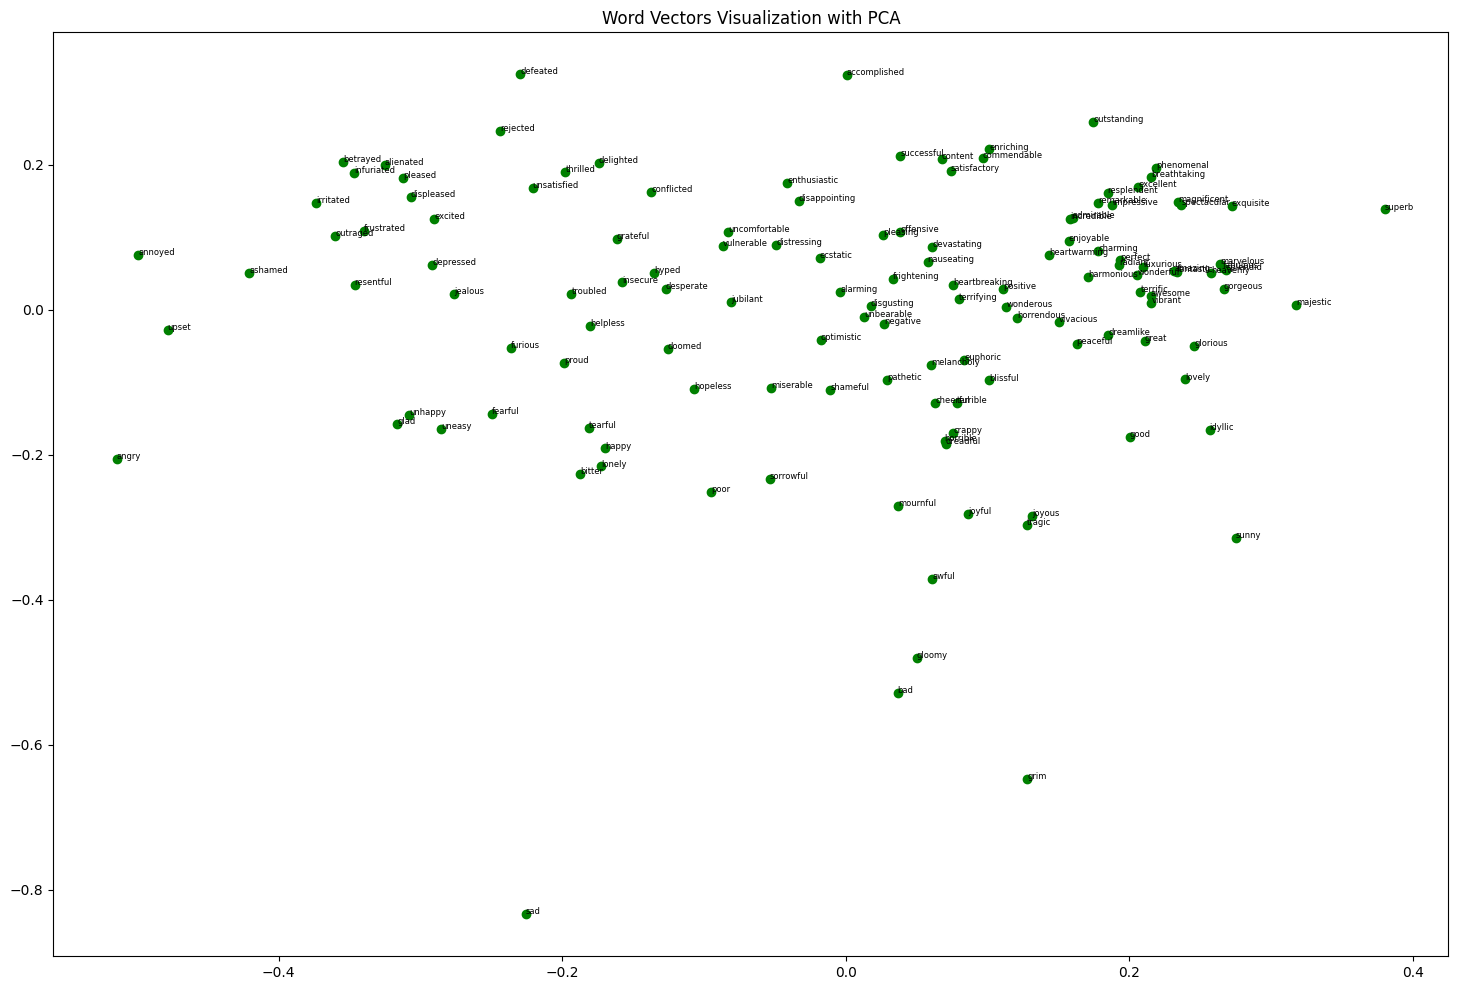

In [137]:
# For 2D visualization, create a scatter plot and annotate each point with its corresponding word to provide context.
plt.figure(figsize=(18, 12))
for i, word in enumerate(selected_words):
    if word in fasttext_vectors:
        plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], color='green')
        plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], word, fontsize=6)

plt.title("Word Vectors Visualization with PCA")
plt.show()

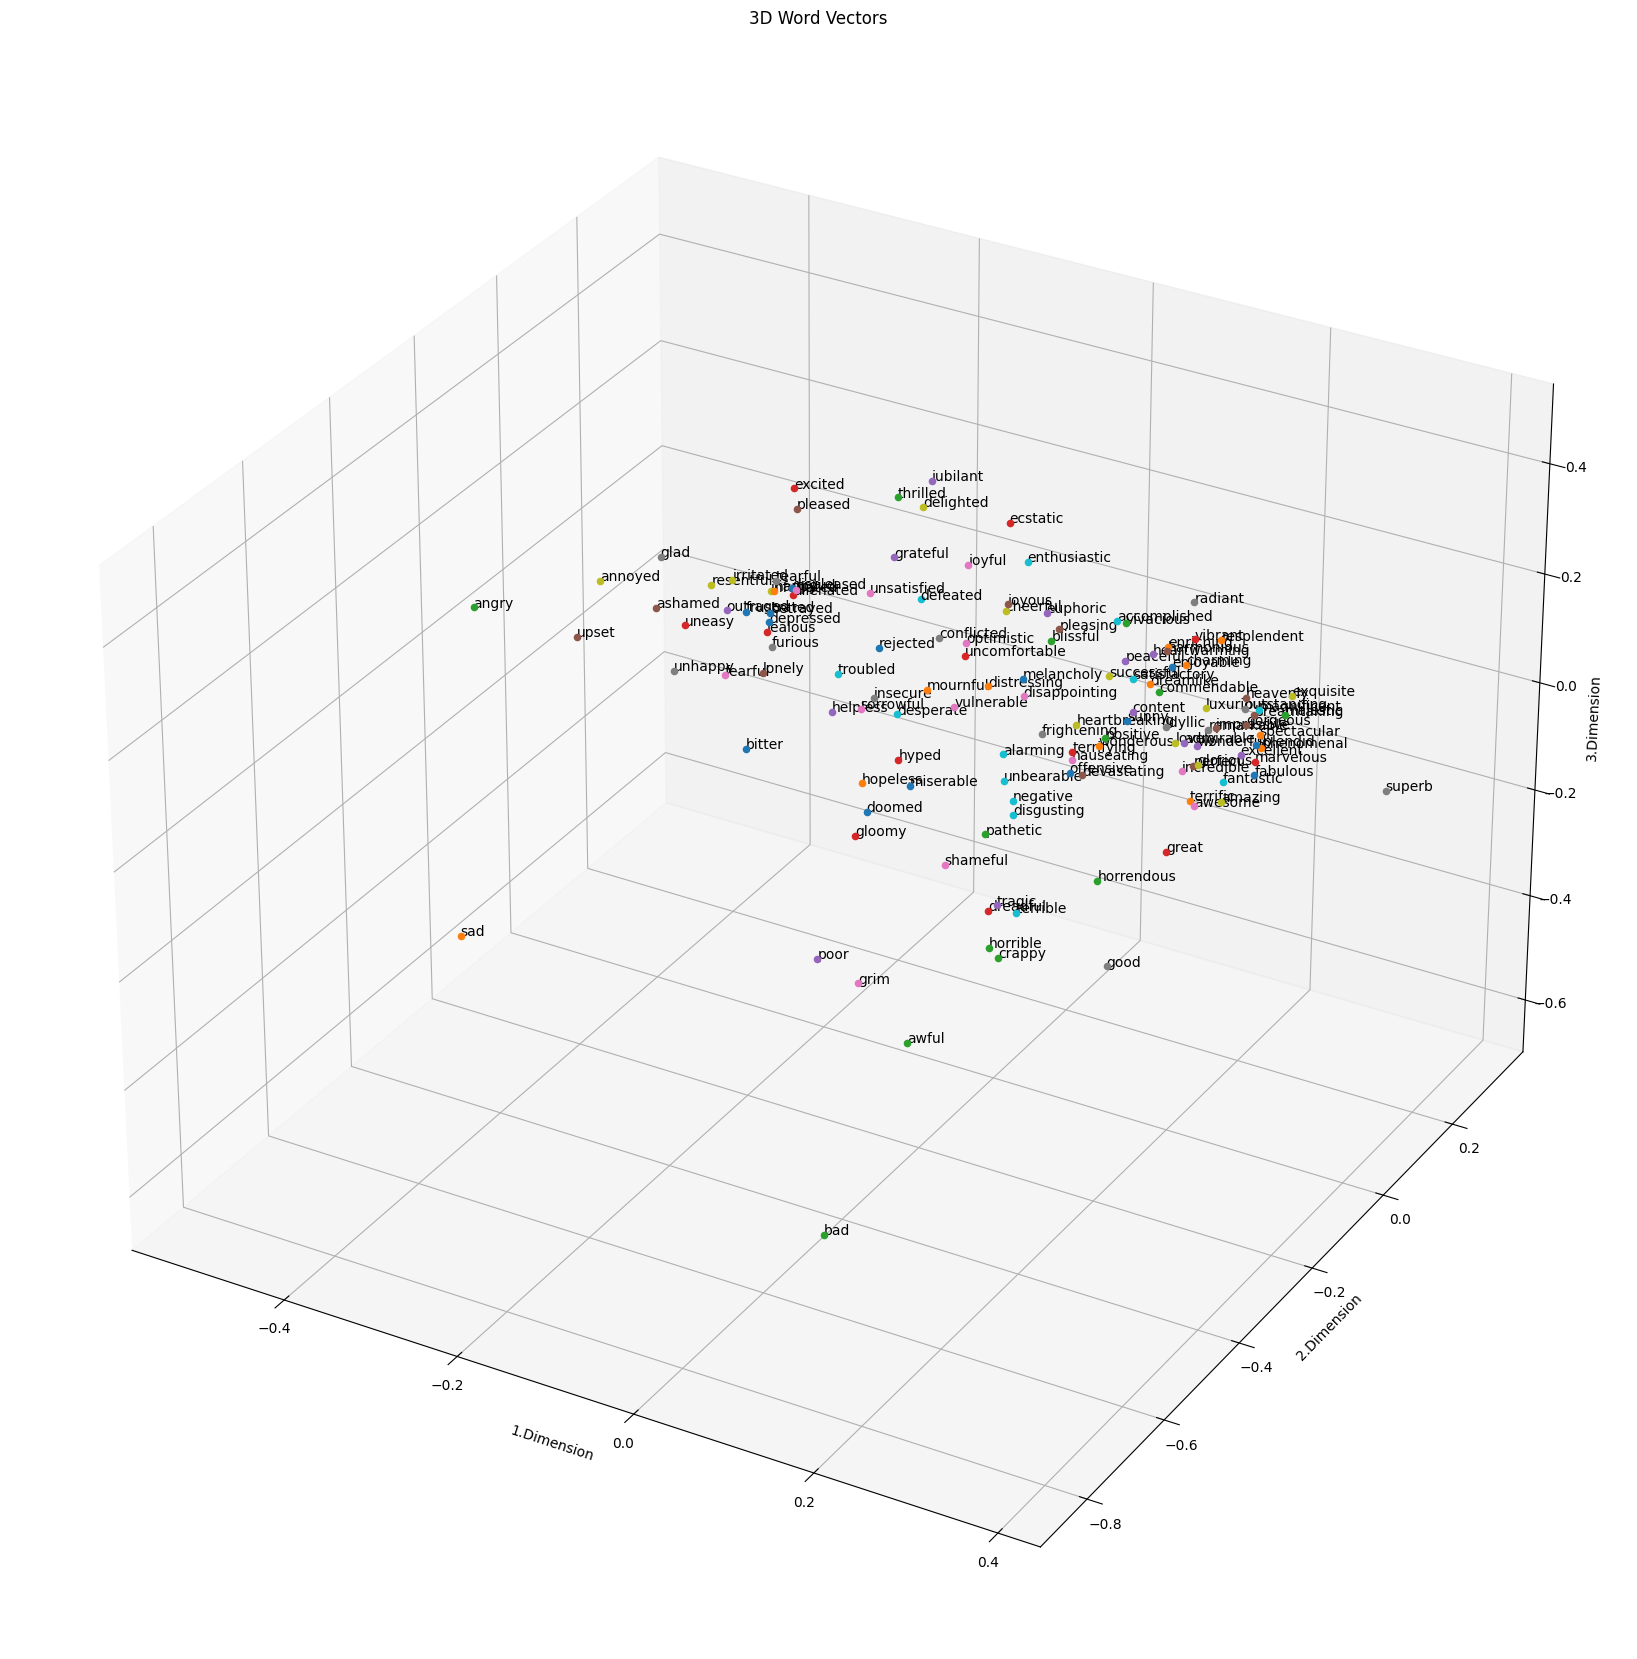

In [138]:
# For 3D visualization, use interactive plotting tools like matplotlib’s Axes3D to explore the spatial relationships between words dynamically.
pca = PCA(n_components=3)
word_vectors_3d = pca.fit_transform(word_vectors)

fig = plt.figure(figsize=(30, 21))
ax = fig.add_subplot(111, projection='3d')

for i, word in enumerate(selected_words):
    if word in fasttext_vectors:
        ax.scatter(word_vectors_3d[i][0], word_vectors_3d[i][1], word_vectors_3d[i][2])
        ax.text(word_vectors_3d[i][0], word_vectors_3d[i][1], word_vectors_3d[i][2], word, size=10)

ax.set_xlabel('1.Dimension')
ax.set_ylabel('2.Dimension')
ax.set_zlabel('3.Dimension')

ax.set_title('3D Word Vectors')

plt.show()

- We see that positive and negative words are generally clustered close to each other. Opposite words are positioned far from each other.

- Since we reduced the 300 dimensions to 2 and 3 dimensions, it was not a completely consistent view due to information losses. For this reason, some exceptions can be observed.

### 4. Creating the Emebdding Matrix

In [139]:
def create_embedding_matrix(word2vec, vocabulary, embedding_dim):
    vocabulary_size = len(vocabulary)

    embedding_matrix = np.zeros((vocabulary_size, embedding_dim))

    for word, index in vocabulary.items():
        if word in word2vec:
            embedding_matrix[index] = word2vec[word]
        else:
            embedding_matrix[index] = np.zeros(embedding_dim)

    return embedding_matrix

# Create a matrix where each row corresponds to the vector representation of a word in the vocabulary
# The embedding matrix will have dimensions [vocab_size, embedding_dim], where embedding_dim is the size of the word vectors

embedding_matrix = create_embedding_matrix(fasttext_vectors, vocabulary, 300)

In [140]:
# Convert the embedding matrix to a PyTorch tensor
# You can create the embedding layer in here or directly in the model
# Using PyTorch’s nn.Embedding.from_pretrained method you load the pre-trained embedding matrix into the embedding layer

embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float)
embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze= False)

### 5. Implementing the IMDBDataset

In [141]:
# Train, validation and test split
inputs = list(df['padded_token_indices'])
labels = list(df['sentiment'])

train_data, control_data, train_labels, control_labels = train_test_split(inputs, labels, test_size=0.3, random_state=0)
val_data, test_data, val_labels, test_labels = train_test_split(control_data, control_labels, test_size=0.33, random_state=0)

In [142]:
# Implement the dataset class
# Combine the padded sequences and corresponding sentiment labels into a dataset structure compatible with PyTorch.
class Dataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence = torch.tensor(self.sequences[index], dtype=torch.long)
        label = torch.tensor(self.labels[index], dtype=torch.float)
        return sequence, label

In [143]:
# Create the train, validation and test dataLoaders
train_dataset = Dataset(train_data, train_labels)
val_dataset = Dataset(val_data, val_labels)
test_dataset = Dataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

- We create a dataset using the padded token list and labels and make the dataset more useful.

### 6. Implementing and Optimizing the Custom LSTM model

In [144]:
# Manually implement the LSTM cell to understand its architecture and functionality.
# Implement forget, input, and output gates.
# Update the cell state and compute the hidden state for each time step.
# Explain your steps and usage of the gates
# Check assignment pdf for more detail on implementation tips

# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        # Define weight matrices and biases for each gate
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.W_f = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_i = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_c = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_o = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x_t, hidden_prev, cell_prev):
        # Concatenate input and previous hidden state
        # Implement forget gate
        # Implement input gate
        # Cell state update
        # Implement output gate

        combined_input = torch.cat((x_t, hidden_prev), dim=1)

        forget_gate = torch.sigmoid(self.W_f(combined_input))
        input_gate = torch.sigmoid(self.W_i(combined_input))
        cell_tilde_t = torch.tanh(self.W_c(combined_input))
        cell_t = forget_gate * cell_prev + input_gate * cell_tilde_t
        output_gate = torch.sigmoid(self.W_o(combined_input))
        hidden_state = output_gate * torch.tanh(cell_t)

        return hidden_state, cell_t

- We define the basic LSTM architecture here. We will use this cell while passing the data.

In [145]:
# Build an LSTM layer by combining one or multiple LSTM cells to process a sequence.

# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMLayer, self).__init__()
        # Integrate the LSTM cell
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm_cell = LSTMCell(input_size, hidden_size)

    def forward(self, x):
        # Initialize hidden and cell states
        batch_size = x.size(0)
        seq_len = x.size(1)

        # Iterate through the sequence and update the hidden and cell states at each step
        # Stack outputs for all time steps

        hidden_state = torch.zeros(batch_size, self.hidden_size).to(x.device)
        cell_state = torch.zeros(batch_size, self.hidden_size).to(x.device)

        outputs = []

        for t in range(seq_len):
            x_t = x[:, t, :]
            hidden_state, cell_state = self.lstm_cell(x_t, hidden_state, cell_state)

            outputs.append(hidden_state.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)

        return outputs

- In this part, Layer processes the time series in order and stores the hidden state resulting from each time step.

In [146]:
# Build an LSTM model. Integrate the embedding layer into the model architecture.
# The embedding layer will convert input indices (from padded sequences) into dense word vectors.
# Decide whether to freeze the embedding weights or allow them to be fine-tuned during training and explain your choice.
# These dense vectors are then passed to the LSTM layer for sequential processing.
# You can provide embedding_matrix as tensor to define embedding layer inside the model class
# Or if you have defined embedding layer before, you can directly use that inside the model class

# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

class SentimentLSTM(nn.Module):
    def __init__(self, vocabulary_size, embedding_dim, hidden_size, output_size, embedding_layer):
        super(SentimentLSTM, self).__init__()
        # Embedding Layer: Use pre-trained Word2Vec embeddings.
        # Custom LSTM Layer: Process the input sequence to generate hidden states.
        # Dense Output Layer: Use a fully connected layer with a sigmoid activation for binary classification.

        self.embedding = embedding_layer

        self.lstm = LSTMLayer(input_size=embedding_dim, hidden_size=hidden_size)

        self.fc = nn.Linear(hidden_size, output_size)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pass input through the embedding layer
        # Get the LSTM layers output
        # Use the last hidden state

        embedded = self.embedding(x)

        lstm_out = self.lstm(embedded)

        final_hidden_state = lstm_out[:, -1, :]

        output = self.fc(final_hidden_state)

        output = self.sigmoid(output).squeeze(-1)
        return output

- In this section, we give inputs to the embedding layer we created earlier, then pass it through the LSTM Layer to find the hidden states and produce a result by connecting the last hidden state to the output.

In [147]:
# Define the hyperparameters and try to optimize your model by experimenting with these
input_size = 300 # This will be the word vector size
hidden_size = 128
epochs = 50 # at least
learning_rate = 0.001
batch_size = 64


model = SentimentLSTM(
    vocabulary_size = len(vocabulary),
    embedding_dim=300,
    hidden_size=hidden_size,
    output_size=1,
    embedding_layer=embedding_layer
)

In [148]:
# Define appropriate loss function for binary classification.
# Choose an optimizer and set its parameters (e.g., learning rate).
# Explain your choice of loss function and optimization algorithm.
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [149]:
# Implement the training loop
# Iterate over the training dataset in mini-batches.
# Implement forward pass, feed the inputs through the network to compute the predictions.
# Validate the model on the validation set periodically to monitor performance

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    correct = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = loss_func(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / len(val_loader.dataset)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


Epoch 1/50, Train Loss: 0.6959, Val Loss: 0.6931, Val Accuracy: 0.50%
Epoch 2/50, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.50%
Epoch 3/50, Train Loss: 0.6931, Val Loss: 0.6931, Val Accuracy: 0.50%
Epoch 4/50, Train Loss: 0.6922, Val Loss: 0.6948, Val Accuracy: 0.49%
Epoch 5/50, Train Loss: 0.6847, Val Loss: 0.6943, Val Accuracy: 0.50%
Epoch 6/50, Train Loss: 0.6832, Val Loss: 0.6946, Val Accuracy: 0.50%
Epoch 7/50, Train Loss: 0.6822, Val Loss: 0.6956, Val Accuracy: 0.50%
Epoch 8/50, Train Loss: 0.6819, Val Loss: 0.6948, Val Accuracy: 0.50%
Epoch 9/50, Train Loss: 0.6820, Val Loss: 0.6966, Val Accuracy: 0.50%
Epoch 10/50, Train Loss: 0.6829, Val Loss: 0.6736, Val Accuracy: 0.61%
Epoch 11/50, Train Loss: 0.6605, Val Loss: 0.6704, Val Accuracy: 0.64%
Epoch 12/50, Train Loss: 0.7261, Val Loss: 0.8062, Val Accuracy: 0.50%
Epoch 13/50, Train Loss: 0.6964, Val Loss: 0.6943, Val Accuracy: 0.50%
Epoch 14/50, Train Loss: 0.6826, Val Loss: 0.6828, Val Accuracy: 0.51%
Epoch 15/50, Tr

- While training the model, we see that the loss and accuracy values ​​​​are almost unchanged in the first 20 epochs. This may be due to the abundance of OOV words. After the 20th epoch, we see that the model has started to learn, the loss value has decreased and the validation accuracy has started to increase.

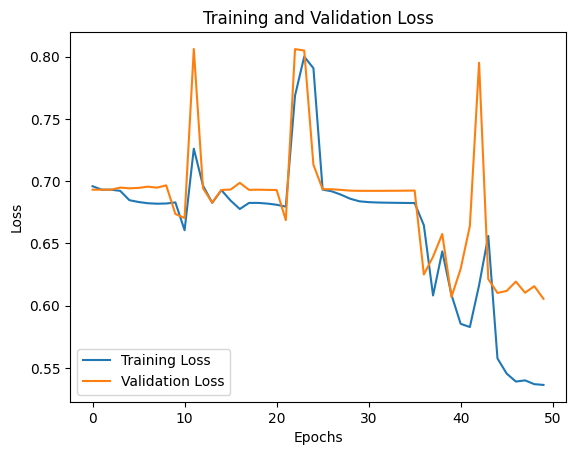

In [150]:
# Visualize the accuracy and loss change of the best model across training and validation datasets
# Make comments on the results

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

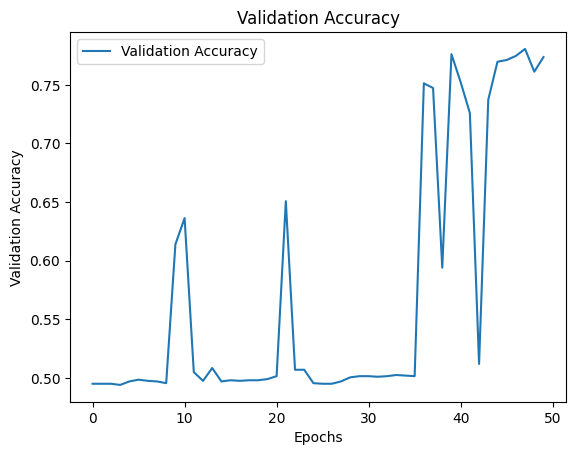

In [151]:
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

### 7. Testing and Analysis (15 points)

In [152]:
# Test the best model on the test set to evaluate its performance.
# Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
# Explain and analyze your findings and results.
# Summarize the performance of the model on the training, validation and test set. Comment on the results.
# Discuss any challenges encountered during training and potential areas for improvement.

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(accuracy)

0.7666666666666667


- In the evaluation made on the test set, the accuracy value was 80%. It is observed that the model has reached a good learning level.

In [39]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import numpy as np

# Step 1: Load the test data
test_file_path = 'subset1000_IMDB_Dataset.csv'  # Adjust this to the test dataset file path
test_data = pd.read_csv(test_file_path)

# Predefine tokenizer and other preprocessing utilities (reuse from training)

# Step 2: Preprocess the test data, apply the steps used during training (change according to your implementation)
test_data["cleaned_tokens"] = test_data["review"].apply(preprocess_text)
test_data["indices"] = test_data["cleaned_tokens"].apply(lambda tokens: [vocabulary.get(token, 0) for token in tokens])
test_data['review_length'] = test_data['indices'].apply(len)
max_len = np.percentile(test_data['review_length'], 95)
padded_test = test_data["indices"].apply(lambda x: pad_sequence(x, int(max_review_length))) # Replace with the maximum sequence length used during training

# Convert to PyTorch tensor
test_tensor = torch.tensor(padded_test, dtype=torch.long)

# Step 3: Load the best-performing model
model_path = 'path/to/best_model.pth'  # Replace with your model's path
model = model
model.eval()

# Step 4: Predict sentiment for the test reviews
batch_size = 32
test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=False)

predictions = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        outputs = model(batch)
        preds = torch.round(outputs).squeeze().tolist()
        predictions.extend(preds)

# Step 5: Map predicted class labels to corresponding class names
class_labels = {0: 'negative', 1: 'positive'}

# Step 6: Save predictions to CSV file
df = pd.DataFrame({'ID': range(1, len(predictions) + 1), 'sentiment': [class_labels[p] for p in predictions]})
df.to_csv('predictions.csv', index=False)

##### Kaggle Result: %88.4 (username = Kağan Soysal)